## Install

In [1]:
! pip install pillow numpy matplotlib opencv-python 
#torch torchvision huggingface-hub

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.2.70 requires numpy<2.0.0,>=1.23.0, but you have numpy 2.2.3 which is incompatible.


## Import

In [2]:

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
# import torch
# from torchvision import transforms, models
# from huggingface_hub import hf_hub_download

## Config

Original image shape: (166, 303, 3)


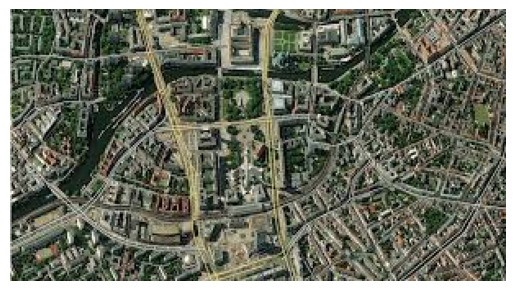

In [12]:
INPUT_IMAGE_PATH = r'C:\Users\sride\OneDrive\Documents\Projects\py\ds\images.jpeg'

orig_bgr = cv2.imread(INPUT_IMAGE_PATH)
if orig_bgr is None:
    raise FileNotFoundError(f"Input image not found: {INPUT_IMAGE_PATH}")
orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
print('Original image shape:', orig_rgb.shape)

plt.axis('off')  
plt.imshow(orig_rgb)


In [ ]:
# %%
# 3) DeepLabV3 segmentation (Cityscapes pre-trained model)

print('Downloading model weights from Hugging Face (Koushim/deeplabv3-resnet50-cityscapes)...')
repo_id = 'Koushim/deeplabv3-resnet50-cityscapes'
model_filename = 'pytorch_model.bin'
model_path = hf_hub_download(repo_id=repo_id, filename=model_filename)
print('Model downloaded to:', model_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=19)
state = torch.load(model_path, map_location=device)
if isinstance(state, dict) and 'state_dict' in state:
    model.load_state_dict(state['state_dict'])
else:
    model.load_state_dict(state)
model.to(device)
model.eval()

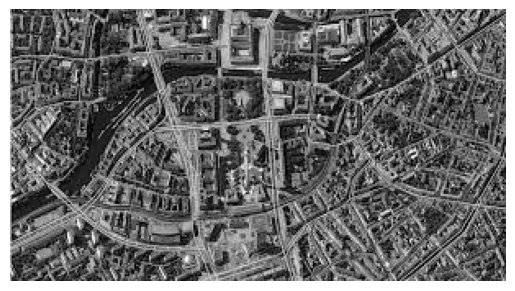

In [15]:
gray = cv2.cvtColor(orig_rgb, cv2.COLOR_RGB2GRAY)
plt.axis('off')  
plt.imshow(gray, cmap='gray')

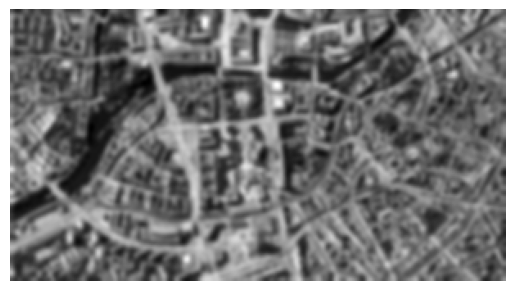

In [16]:
blur = cv2.GaussianBlur(gray, (7,7), 0)
plt.axis('off')  
plt.imshow(blur, cmap='gray')

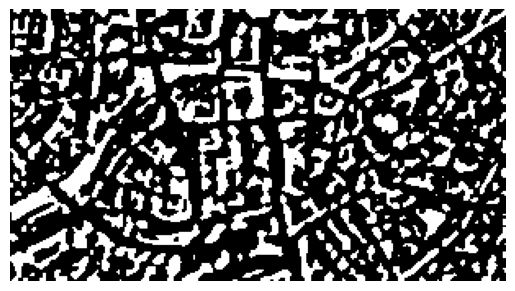

In [17]:
adapt = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY_INV, 25, 9)
plt.axis('off')
plt.imshow(adapt, cmap='gray')

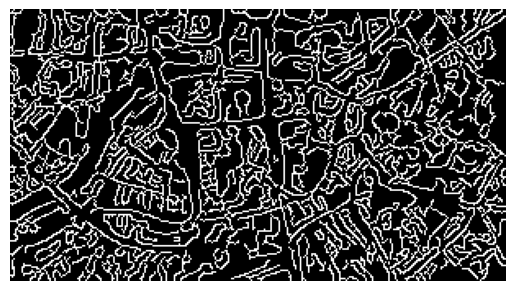

In [18]:
edges = cv2.Canny(blur, 50, 150)
plt.axis('off')
plt.imshow(edges, cmap='gray')

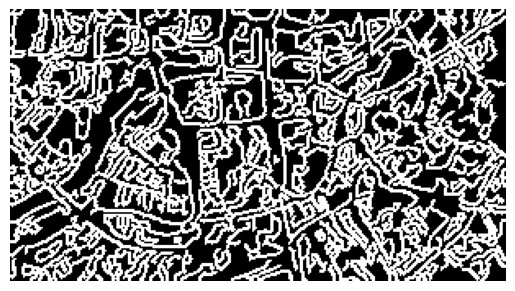

In [27]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
dil = cv2.dilate(edges, kernel, iterations=1)
plt.axis('off')
plt.imshow(dil, cmap='gray')

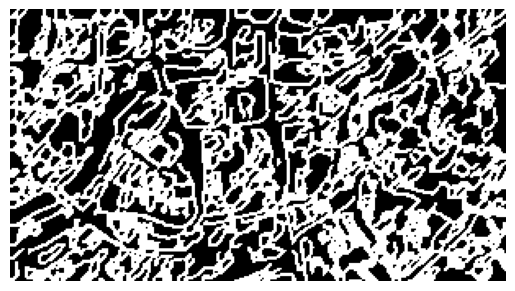

In [42]:
closed = cv2.morphologyEx(dil, cv2.MORPH_CLOSE, kernel, iterations=1)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=1)
plt.axis('off')
plt.imshow(opened, cmap='gray')

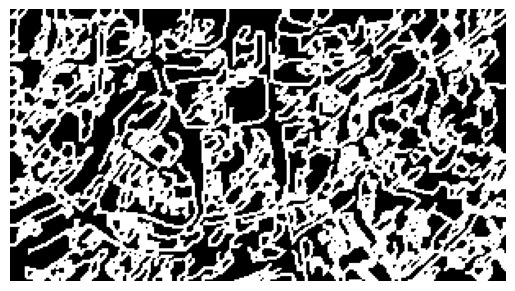

In [43]:
num_labels, labels_im = cv2.connectedComponents(opened)
areas = [np.sum(labels_im==i) for i in range(1, num_labels)]
median_area = np.median(areas) if len(areas) else 0
mask_cv = np.zeros_like(gray)
for i, area in enumerate(areas, start=1):
    if area > max(100, median_area*0.5):
        mask_cv[labels_im==i] = 255

plt.axis('off')
plt.imshow(mask_cv, cmap='gray')

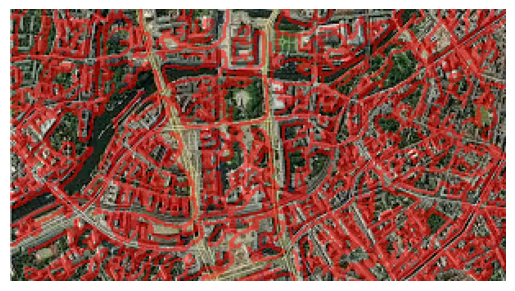

In [44]:

overlay = orig_rgb.copy()
red = np.array([255,0,0], dtype=np.uint8)
alpha = 0.5
overlay[mask_cv==255] = (overlay[mask_cv==255] * (1-alpha) + red * alpha).astype(np.uint8)
plt.axis('off')
plt.imshow(overlay)




In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((360,720)),
    transforms.ToTensor(),
])

img_pil = Image.fromarray(orig_rgb)
input_tensor = preprocess(img_pil).unsqueeze(0).to(device)
print('Input tensor shape (model):', input_tensor.shape)


In [ ]:
with torch.no_grad():
    out = model(input_tensor)['out']
    probs = torch.softmax(out, dim=1)
    pred = torch.argmax(probs, dim=1).squeeze(0).cpu().numpy()

print('Prediction shape (model output):', pred.shape)

In [ ]:

pred_rgb = (pred.astype(np.uint8) * (255 // pred.max() if pred.max()>0 else 1)).astype(np.uint8)
pred_resized = cv2.resize(pred_rgb, (orig_rgb.shape[1], orig_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)
show(pred_resized, 'DeepLabv3 prediction (Cityscapes trainId colors)')
cv2.imwrite(os.path.join(OUTPUT_DIR, 'deeplab_pred.png'), pred_resized)


In [ ]:
road_train_id = 0
road_mask = (cv2.resize(pred, (orig_rgb.shape[1], orig_rgb.shape[0]), interpolation=cv2.INTER_NEAREST) == road_train_id).astype(np.uint8)*255
show(road_mask, 'Road mask (from Cityscapes model)')
cv2.imwrite(os.path.join(OUTPUT_DIR, 'deeplab_road_mask.png'), road_mask)

In [ ]:
overlay_dl = orig_rgb.copy()
overlay_dl[road_mask==255] = (overlay_dl[road_mask==255] * (1-alpha) + red * alpha).astype(np.uint8)
show(overlay_dl, 'DeepLab overlay (road in red)')
cv2.imwrite(os.path.join(OUTPUT_DIR, 'deeplab_overlay.png'), cv2.cvtColor(overlay_dl, cv2.COLOR_RGB2BGR))

In [ ]:
# %%
# 4) Compare side-by-side: original, OpenCV overlay, DeepLab overlay
fig, axs = plt.subplots(1,3, figsize=(18,8))
axs[0].imshow(orig_rgb); axs[0].set_title('Original'); axs[0].axis('off')
axs[1].imshow(overlay); axs[1].set_title('OpenCV overlay'); axs[1].axis('off')
axs[2].imshow(overlay_dl); axs[2].set_title('DeepLab overlay'); axs[2].axis('off')
plt.tight_layout()
plt.show()

print('All outputs saved to', os.path.abspath(OUTPUT_DIR))